# Sidebet Optimizer Prototype

**TGOES - Theoretical Gameplay Optimization Engine Suite**

Interactive dashboard for sidebet placement optimization using Bayesian survival analysis.

**Goals:**
- 70%: WHEN to place a sidebet (optimal tick)
- 30%: WHETHER to place at all (game selection)

**Key Mechanics:**
- Sidebet window: 40 ticks (configurable)
- Default payout: 5x (win if rug occurs within window)
- Breakeven probability: 16.67% for 5x, 10% for 10x

**Run with Voila:**
```bash
voila notebooks/sidebet_optimizer_prototype.ipynb --theme=dark --port=8866
```

In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION (hidden in Voila)
# ============================================================================
import json
import warnings
from pathlib import Path

import ipywidgets as widgets
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import HTML, display
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

# Data path (games.json with 2,835 known outcomes)
GAMES_JSON_PATH = Path(
    "/home/devops/Desktop/VECTRA-PLAYER/src/rugs_recordings/PRNG CRAK/explorer_v2/data/games.json"
)

# Catppuccin Mocha theme colors
THEME = {
    "bg": "#1e1e2e",
    "surface0": "#313244",
    "surface1": "#45475a",
    "text": "#cdd6f4",
    "subtext": "#a6adc8",
    "mauve": "#cba6f7",
    "blue": "#89b4fa",
    "green": "#a6e3a1",
    "red": "#f38ba8",
    "yellow": "#f9e2af",
    "peach": "#fab387",
    "teal": "#94e2d5",
}

In [2]:
# ============================================================================
# DATA LOADING (hidden in Voila)
# ============================================================================


def load_games_from_json(path: Path = GAMES_JSON_PATH) -> pd.DataFrame:
    """
    Load game data from games.json.

    Schema:
    - game_id: Unique identifier
    - timestamp_ms: Unix timestamp
    - server_seed: Provably fair seed
    - peak_multiplier: Max price reached
    - final_price: Price at rug
    - tick_duration: Number of ticks before rug
    - rugged: Whether game rugged (all True in this dataset)
    """
    if not path.exists():
        raise FileNotFoundError(f"games.json not found at {path}")

    with open(path) as f:
        games = json.load(f)

    df = pd.DataFrame(games)

    # Rename for consistency
    df = df.rename(columns={"tick_duration": "rug_tick", "peak_multiplier": "peak"})

    # Filter out very short games
    df = df[df["rug_tick"] >= 10]

    return df


# Load data
games_df = load_games_from_json()
print(f"Loaded {len(games_df)} games")
print(
    f"Tick duration: median={games_df['rug_tick'].median():.0f}, range=[{games_df['rug_tick'].min()}, {games_df['rug_tick'].max()}]"
)

Loaded 2723 games
Tick duration: median=149, range=[10, 1815]


In [3]:
# ============================================================================
# BAYESIAN SURVIVAL MODEL (Inlined - no external dependencies)
# ============================================================================


class BayesianSurvivalModel:
    """
    Bayesian survival analysis for rug prediction.

    Models P(rug in next N ticks | game_age) using:
    - Hazard function: h(t) = P(rug at tick t | survived to t)
    - Survival function: S(t) = P(game survives past tick t)
    """

    def __init__(self, games_df: pd.DataFrame):
        self.games_df = games_df
        self.max_tick = int(games_df["rug_tick"].max()) + 1
        self.hazard_rates = self._compute_baseline_hazard()
        self.survival = self._compute_survival_function()

    def _compute_baseline_hazard(self) -> np.ndarray:
        """Compute baseline hazard function h(t)."""
        rug_counts = np.zeros(self.max_tick)
        survival_counts = np.zeros(self.max_tick)

        for rug_tick in self.games_df["rug_tick"]:
            for t in range(int(rug_tick) + 1):
                survival_counts[t] += 1
            if int(rug_tick) < self.max_tick:
                rug_counts[int(rug_tick)] += 1

        # Hazard rate = rugs at t / games surviving to t
        hazard = np.divide(
            rug_counts, survival_counts, out=np.zeros_like(rug_counts), where=survival_counts > 0
        )

        # Smooth with moving average
        window = 10
        return np.convolve(hazard, np.ones(window) / window, mode="same")

    def _compute_survival_function(self) -> np.ndarray:
        """Compute survival function S(t) = exp(-cumulative_hazard)."""
        cumulative_hazard = np.cumsum(self.hazard_rates)
        return np.exp(-cumulative_hazard)

    def predict_rug_probability(self, current_tick: int, window: int = 40) -> float:
        """
        Predict P(rug in next window ticks | current_tick).

        This is the WIN probability for a sidebet.
        """
        if current_tick >= len(self.survival):
            return 1.0

        S_now = self.survival[current_tick]
        future_tick = min(current_tick + window, len(self.survival) - 1)
        S_future = self.survival[future_tick]

        if S_now <= 0:
            return 0.5

        return 1 - (S_future / S_now)

    def get_tick_range(self) -> tuple:
        """Return valid tick range."""
        return (0, len(self.hazard_rates) - 1)


# Initialize model
survival_model = BayesianSurvivalModel(games_df)
print(f"Survival model initialized (max tick: {survival_model.max_tick})")

Survival model initialized (max tick: 1816)


In [4]:
# ============================================================================
# EXPECTED VALUE & KELLY FUNCTIONS (Inlined)
# ============================================================================


def expected_value(p_win: float, payout_mult: int = 5, bet_amount: float = 0.001) -> float:
    """
    Compute expected value of a sidebet.

    EV = bet * [P(win) * (multiplier + 1) - 1]

    For 5x payout: Win returns 5x bet (net +4x), lose returns 0 (net -1x)
    """
    return bet_amount * (p_win * (payout_mult + 1) - 1)


def breakeven_probability(payout_mult: int = 5) -> float:
    """
    Compute breakeven win probability.

    P_breakeven = 1 / (multiplier + 1)
    5x -> 16.67%, 10x -> 9.09%, 20x -> 4.76%
    """
    return 1.0 / (payout_mult + 1)


def kelly_criterion(p_win: float, payout_mult: int = 5) -> float:
    """
    Compute Kelly Criterion for optimal bet sizing.

    f* = (p * b - q) / b
    where b = net odds (payout_mult - 1), q = 1 - p

    Returns fraction of bankroll to bet (0-1).
    """
    b = payout_mult - 1  # Net odds (5x = 4:1 net)
    p = p_win
    q = 1 - p

    kelly = (p * b - q) / b
    return max(0.0, kelly)


# Test
print(f"Breakeven for 5x payout: {breakeven_probability(5):.2%}")
print(f"Breakeven for 10x payout: {breakeven_probability(10):.2%}")
print(f"Kelly @ 25% win rate, 5x: {kelly_criterion(0.25, 5):.2%}")

Breakeven for 5x payout: 16.67%
Breakeven for 10x payout: 9.09%
Kelly @ 25% win rate, 5x: 6.25%


In [5]:
# ============================================================================
# INTERACTIVE WIDGETS
# ============================================================================

# Parameter widgets
sidebet_window = widgets.IntSlider(
    min=10,
    max=100,
    value=40,
    step=5,
    description="Window (ticks):",
    style={"description_width": "100px"},
    layout=widgets.Layout(width="350px"),
)

payout_mult = widgets.RadioButtons(
    options=[("5x", 5), ("10x", 10), ("20x", 20)],
    value=5,
    description="Payout:",
    style={"description_width": "100px"},
)

bankroll = widgets.FloatSlider(
    min=0.01,
    max=2.0,
    value=0.1,
    step=0.01,
    description="Bankroll (SOL):",
    style={"description_width": "100px"},
    layout=widgets.Layout(width="350px"),
)

kelly_frac = widgets.FloatSlider(
    min=0.1,
    max=1.0,
    value=0.25,
    step=0.05,
    description="Kelly %:",
    style={"description_width": "100px"},
    layout=widgets.Layout(width="350px"),
)

# Output widgets for plots
survival_output = widgets.Output()
ev_output = widgets.Output()
heatmap_output = widgets.Output()
recommendations_output = widgets.Output()

print("Widgets initialized")

Widgets initialized


In [6]:
# ============================================================================
# PLOTLY VISUALIZATION FUNCTIONS
# ============================================================================


def create_survival_plot(model: BayesianSurvivalModel) -> go.Figure:
    """Create hazard rate and survival function plots."""
    ticks = np.arange(len(model.hazard_rates))

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=("Hazard Rate h(t)", "Survival Function S(t)"),
        horizontal_spacing=0.12,
    )

    # Hazard rate
    fig.add_trace(
        go.Scatter(
            x=ticks,
            y=model.hazard_rates,
            mode="lines",
            name="Hazard",
            line=dict(color=THEME["red"], width=2),
            hovertemplate="Tick: %{x}<br>h(t): %{y:.4f}<extra></extra>",
        ),
        row=1,
        col=1,
    )

    # Survival function
    fig.add_trace(
        go.Scatter(
            x=ticks,
            y=model.survival,
            mode="lines",
            name="Survival",
            line=dict(color=THEME["blue"], width=2),
            fill="tozeroy",
            fillcolor="rgba(137, 180, 250, 0.2)",
            hovertemplate="Tick: %{x}<br>S(t): %{y:.2%}<extra></extra>",
        ),
        row=1,
        col=2,
    )

    fig.update_layout(
        height=350,
        showlegend=False,
        paper_bgcolor=THEME["bg"],
        plot_bgcolor=THEME["surface0"],
        font=dict(color=THEME["text"], family="JetBrains Mono, monospace"),
        margin=dict(l=50, r=20, t=40, b=40),
    )

    fig.update_xaxes(title_text="Tick", gridcolor=THEME["surface1"], row=1, col=1)
    fig.update_xaxes(title_text="Tick", gridcolor=THEME["surface1"], row=1, col=2)
    fig.update_yaxes(title_text="P(rug at t | survived)", gridcolor=THEME["surface1"], row=1, col=1)
    fig.update_yaxes(title_text="P(survives past t)", gridcolor=THEME["surface1"], row=1, col=2)

    return fig


def create_ev_plot(model: BayesianSurvivalModel, window: int, payout: int) -> go.Figure:
    """Create EV and win probability by tick plots."""
    ticks = np.arange(10, min(600, model.max_tick - window), 5)

    p_wins = [model.predict_rug_probability(t, window) for t in ticks]
    evs = [expected_value(p, payout) for p in p_wins]
    kellys = [kelly_criterion(p, payout) for p in p_wins]

    breakeven = breakeven_probability(payout)

    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            f"Win Probability (window={window} ticks)",
            f"Expected Value ({payout}x payout)",
        ),
        vertical_spacing=0.15,
    )

    # Win probability
    fig.add_trace(
        go.Scatter(
            x=ticks,
            y=p_wins,
            mode="lines",
            name="P(win)",
            line=dict(color=THEME["mauve"], width=2),
            hovertemplate="Tick: %{x}<br>P(win): %{y:.2%}<extra></extra>",
        ),
        row=1,
        col=1,
    )

    # Breakeven line
    fig.add_hline(
        y=breakeven,
        row=1,
        col=1,
        line=dict(color=THEME["yellow"], dash="dash"),
        annotation_text=f"Breakeven ({breakeven:.1%})",
        annotation_position="right",
    )

    # EV plot
    colors = [THEME["green"] if ev > 0 else THEME["red"] for ev in evs]

    # Positive EV area
    pos_ticks = [t for t, ev in zip(ticks, evs) if ev > 0]
    pos_evs = [ev for ev in evs if ev > 0]
    if pos_ticks:
        fig.add_trace(
            go.Scatter(
                x=pos_ticks,
                y=pos_evs,
                mode="lines",
                name="+EV Zone",
                line=dict(color=THEME["green"], width=2),
                fill="tozeroy",
                fillcolor="rgba(166, 227, 161, 0.3)",
                hovertemplate="Tick: %{x}<br>EV: %{y:.6f} SOL<extra></extra>",
            ),
            row=2,
            col=1,
        )

    # Negative EV area
    neg_ticks = [t for t, ev in zip(ticks, evs) if ev <= 0]
    neg_evs = [ev for ev in evs if ev <= 0]
    if neg_ticks:
        fig.add_trace(
            go.Scatter(
                x=neg_ticks,
                y=neg_evs,
                mode="lines",
                name="-EV Zone",
                line=dict(color=THEME["red"], width=2),
                fill="tozeroy",
                fillcolor="rgba(243, 139, 168, 0.3)",
                hovertemplate="Tick: %{x}<br>EV: %{y:.6f} SOL<extra></extra>",
            ),
            row=2,
            col=1,
        )

    fig.add_hline(y=0, row=2, col=1, line=dict(color=THEME["text"], width=1))

    fig.update_layout(
        height=500,
        showlegend=True,
        legend=dict(orientation="h", y=-0.1),
        paper_bgcolor=THEME["bg"],
        plot_bgcolor=THEME["surface0"],
        font=dict(color=THEME["text"], family="JetBrains Mono, monospace"),
        margin=dict(l=60, r=20, t=40, b=60),
    )

    fig.update_xaxes(title_text="Tick", gridcolor=THEME["surface1"])
    fig.update_yaxes(title_text="Win Probability", gridcolor=THEME["surface1"], row=1, col=1)
    fig.update_yaxes(title_text="EV (SOL per 0.001 bet)", gridcolor=THEME["surface1"], row=2, col=1)

    return fig


def create_heatmap(model: BayesianSurvivalModel, window: int, payout: int) -> go.Figure:
    """Create tick vs window size heatmap showing optimal entry zones."""
    # Create tick x window matrix
    tick_range = np.arange(50, 500, 25)
    window_range = np.arange(20, 100, 10)

    ev_matrix = np.zeros((len(window_range), len(tick_range)))

    for i, w in enumerate(window_range):
        for j, t in enumerate(tick_range):
            p_win = model.predict_rug_probability(int(t), int(w))
            ev_matrix[i, j] = expected_value(p_win, payout)

    # Normalize to percentage for color scale
    ev_pct = ev_matrix * 1000  # Convert to per-SOL basis

    fig = go.Figure(
        data=go.Heatmap(
            z=ev_pct,
            x=tick_range,
            y=window_range,
            colorscale=[
                [0, THEME["red"]],
                [0.4, THEME["surface1"]],
                [0.5, THEME["yellow"]],
                [0.6, THEME["surface1"]],
                [1, THEME["green"]],
            ],
            zmid=0,
            colorbar=dict(title="EV (per SOL)", ticksuffix="%"),
            hovertemplate="Tick: %{x}<br>Window: %{y} ticks<br>EV: %{z:.2f}%<extra></extra>",
        )
    )

    # Highlight current window selection
    fig.add_hline(
        y=window,
        line=dict(color=THEME["mauve"], width=2, dash="dash"),
        annotation_text=f"Selected: {window} ticks",
        annotation_position="right",
    )

    fig.update_layout(
        title=f"EV Heatmap: Entry Tick vs Window Size ({payout}x payout)",
        xaxis_title="Entry Tick",
        yaxis_title="Sidebet Window (ticks)",
        height=400,
        paper_bgcolor=THEME["bg"],
        plot_bgcolor=THEME["surface0"],
        font=dict(color=THEME["text"], family="JetBrains Mono, monospace"),
        margin=dict(l=60, r=20, t=60, b=40),
    )

    return fig


print("Visualization functions loaded")

Visualization functions loaded


In [7]:
# ============================================================================
# UPDATE CALLBACKS
# ============================================================================


def update_all(change=None):
    """Update all plots when parameters change."""
    window = sidebet_window.value
    payout = payout_mult.value
    bank = bankroll.value
    kelly_fraction = kelly_frac.value

    # Update survival plot
    with survival_output:
        survival_output.clear_output(wait=True)
        fig = create_survival_plot(survival_model)
        fig.show()

    # Update EV plot
    with ev_output:
        ev_output.clear_output(wait=True)
        fig = create_ev_plot(survival_model, window, payout)
        fig.show()

    # Update heatmap
    with heatmap_output:
        heatmap_output.clear_output(wait=True)
        fig = create_heatmap(survival_model, window, payout)
        fig.show()

    # Update recommendations
    with recommendations_output:
        recommendations_output.clear_output(wait=True)

        # Find optimal entry tick
        best_tick = 0
        best_ev = -1
        best_p_win = 0

        for t in range(50, min(500, survival_model.max_tick - window)):
            p_win = survival_model.predict_rug_probability(t, window)
            ev = expected_value(p_win, payout)
            if ev > best_ev:
                best_ev = ev
                best_tick = t
                best_p_win = p_win

        kelly_bet = kelly_criterion(best_p_win, payout) * kelly_fraction
        bet_size = bank * kelly_bet
        breakeven = breakeven_probability(payout)

        html = f"""
        <div style="background: {THEME["surface0"]}; padding: 20px; border-radius: 8px; font-family: 'JetBrains Mono', monospace;">
            <h3 style="color: {THEME["mauve"]}; margin-top: 0;">Strategy Recommendations</h3>

            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
                <div style="background: {THEME["surface1"]}; padding: 15px; border-radius: 6px;">
                    <h4 style="color: {THEME["green"]}; margin: 0 0 10px 0;">Optimal Entry</h4>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">Tick: <strong>{best_tick}</strong></p>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">P(win): <strong>{best_p_win:.2%}</strong></p>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">EV: <strong style="color: {THEME["green"] if best_ev > 0 else THEME["red"]};">{best_ev * 1000:.2f}%</strong> per SOL</p>
                </div>

                <div style="background: {THEME["surface1"]}; padding: 15px; border-radius: 6px;">
                    <h4 style="color: {THEME["peach"]}; margin: 0 0 10px 0;">Bet Sizing ({kelly_fraction * 100:.0f}% Kelly)</h4>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">Bankroll: <strong>{bank:.3f} SOL</strong></p>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">Bet size: <strong>{bet_size:.6f} SOL</strong></p>
                    <p style="color: {THEME["text"]}; margin: 5px 0;">% of bankroll: <strong>{kelly_bet * 100:.2f}%</strong></p>
                </div>
            </div>

            <div style="margin-top: 20px; padding: 15px; background: {THEME["bg"]}; border-radius: 6px;">
                <h4 style="color: {THEME["teal"]}; margin: 0 0 10px 0;">Rules</h4>
                <p style="color: {THEME["green"]}; margin: 5px 0;">
                    <span style="font-size: 1.2em;">PLACE</span> when: tick > 200, P(win) > {breakeven:.1%}
                </p>
                <p style="color: {THEME["red"]}; margin: 5px 0;">
                    <span style="font-size: 1.2em;">AVOID</span> when: tick < 100, P(win) < {breakeven:.1%}
                </p>
            </div>
        </div>
        """
        display(HTML(html))


# Connect widgets to update function
sidebet_window.observe(update_all, names="value")
payout_mult.observe(update_all, names="value")
bankroll.observe(update_all, names="value")
kelly_frac.observe(update_all, names="value")

print("Callbacks connected")

Callbacks connected


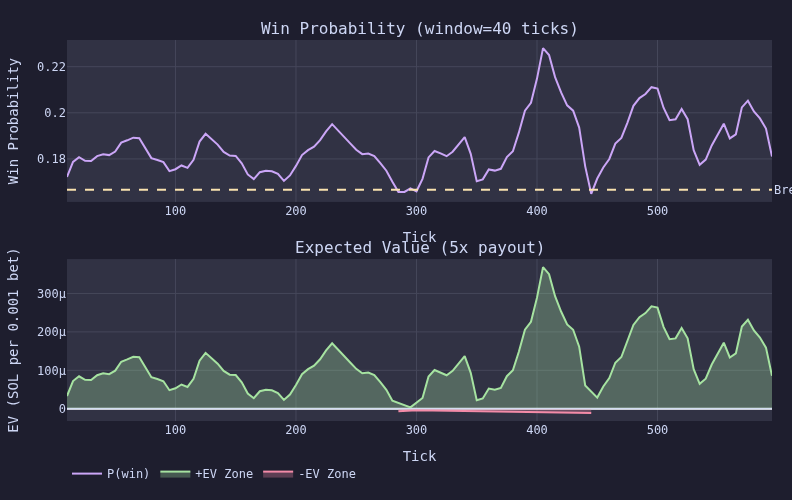

In [8]:
# ============================================================================
# DASHBOARD LAYOUT (Visible in Voila)
# ============================================================================

# Title
title_html = f"""
<div style="background: {THEME["mantle"] if "mantle" in THEME else THEME["surface0"]};
            padding: 20px; margin-bottom: 20px; border-radius: 8px;">
    <h1 style="color: {THEME["mauve"]}; margin: 0;">Sidebet Optimizer</h1>
    <p style="color: {THEME["subtext"]}; margin: 5px 0 0 0;">
        TGOES - Bayesian Survival Analysis | {len(games_df)} games analyzed
    </p>
</div>
"""

# Parameter controls
params_box = widgets.VBox(
    [
        widgets.HTML(f'<h3 style="color: {THEME["peach"]}; margin: 0 0 10px 0;">Parameters</h3>'),
        sidebet_window,
        payout_mult,
        bankroll,
        kelly_frac,
    ],
    layout=widgets.Layout(
        padding="15px",
        border=f"1px solid {THEME['surface1']}",
        border_radius="8px",
        margin="0 0 20px 0",
    ),
)

# Main layout
dashboard = widgets.VBox(
    [
        widgets.HTML(title_html),
        params_box,
        widgets.HTML(
            f'<h3 style="color: {THEME["lavender"] if "lavender" in THEME else THEME["blue"]};">Survival Analysis</h3>'
        ),
        survival_output,
        widgets.HTML(
            f'<h3 style="color: {THEME["lavender"] if "lavender" in THEME else THEME["blue"]};">Expected Value by Tick</h3>'
        ),
        ev_output,
        widgets.HTML(
            f'<h3 style="color: {THEME["lavender"] if "lavender" in THEME else THEME["blue"]};">Entry Zone Heatmap</h3>'
        ),
        heatmap_output,
        recommendations_output,
    ]
)

# Initial render
display(dashboard)
update_all()

---

## Methodology

### Survival Analysis

We model game duration using **survival analysis**:

- **Hazard function** $h(t)$: Instantaneous rug probability at tick $t$, given survival to $t$
- **Survival function** $S(t) = e^{-\int_0^t h(u)du}$: Probability game survives past tick $t$

### Win Probability

For a sidebet placed at tick $t$ with window $w$:

$$P(\text{win}) = P(\text{rug in } [t, t+w]) = 1 - \frac{S(t+w)}{S(t)}$$

### Expected Value

For payout multiplier $m$ (e.g., 5x):

$$EV = \text{bet} \times [P(\text{win}) \times (m+1) - 1]$$

Breakeven: $P_{BE} = \frac{1}{m+1}$ (16.67% for 5x, 10% for 10x)

### Kelly Criterion

Optimal bet fraction:

$$f^* = \frac{p \times b - q}{b}$$

where $b = m - 1$ (net odds), $q = 1 - p$.

**Recommendation**: Use 25% Kelly (fractional Kelly) to reduce variance.